This Colab demonstrates how you can use the Firebase Admin Python SDK from a Jupyter notebook to manage your Firebase-hosted ML models.

# **1. Upload the json service account key file for your project to the runtime**

In [ ]:
import ipywidgets

uploader = ipywidgets.FileUpload(
    accept='.json',
    multiple=False
)
service_acct_file = {}
def handle_upload(change):
    service_acct_file['name'] = next(iter(change['owner'].value))
    service_acct_file['data'] = change['owner'].value[service_acct_file['name']]['content']
    with open(service_acct_file['name'], 'wb') as f:
        f.write(service_acct_file['data'])
    print('Uploaded {}'.format(service_acct_file['name']))
uploader.observe(handle_upload, names='data')
display(uploader)


FileUpload(value={}, accept='.json', description='Upload')

Uploaded fir-ml-9258b-firebase-adminsdk-391on-fe5321504b.json


# **2. Set your Google Application Credentials location**

Set the `GOOGLE_APPLICATION_CREDENTIALS` environmental variable to the location of the key file:

In [ ]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.realpath(service_acct_file['name'])

# **3. Initialize Firebase Admin**

Import the `firebase_admin` module and initialize the SDK with the name of your Storage bucket. Be sure the Storage bucket is in the same Firebase project as your service account. Your project's default bucket looks like `your-project-id.appspot.com`.

In [ ]:

storage_bucket = input('Storage bucket (no "gs://"): ')

Storage bucket (no "gs://"): fir-ml-9258b.appspot.com


In [ ]:
import firebase_admin
from firebase_admin import ml

firebase_admin.initialize_app(options={'storageBucket': storage_bucket})

# **4. Training the Machine Learning Dataset Generation**

In [ ]:
import numpy as np
import pandas as pd

# Generate random stowage data
n_samples = 1000
cargo_types = ['1', '2', '3', '4',] #1 is flamable, 2 is hazardous, 3 is refrigerated, 4 is normal
destinations = [1, 2, 3, 4]
data = pd.DataFrame({
    'destinations': np.random.choice(destinations, n_samples),
    'cargo_type': np.random.choice(cargo_types, n_samples),
    'cargo_weight': np.random.randint(2000, 24000, n_samples),
    'Location': np.zeros(n_samples)
})

# Define the function to calculate the coordinate based on cargo type and weight
def calculate_coordinate(row):
    if row['cargo_type'] == '4' and row['cargo_weight'] > 13000 and row['destinations'] > 3:
        x = 2
    elif row['cargo_type'] == '4' and row['cargo_weight'] < 13000 and row['destinations'] < 2:
        x = 1
    elif row['cargo_type'] != '4' and  row['cargo_weight'] < 13000 and row['destinations'] < 2:
        x = 4
    elif row['cargo_type'] == '4' or '3' and row['cargo_weight'] > 13000 and row['destinations'] > 3:
        x = 3
    else:
        x = 0

    row['Location'] = x
    return row

# Apply the function to the data
data = data.apply(calculate_coordinate, axis=1)

# Save the data to a CSV file
data.to_csv('dummy_data.csv', index=False)

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib

# Load the dummy data from CSV file
df = pd.read_csv("dummy_data.csv")

# Split the data into features and target
X = data.iloc[:, 0:3].values
y = data.iloc[:, 3].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the random forest classifier
rfc = RandomForestClassifier(n_estimators=1000, random_state=42)
rfc.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rfc.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Save the trained model using joblib
joblib.dump(rfc, "rfc_model.joblib")

Accuracy: 1.0


['rfc_model.joblib']

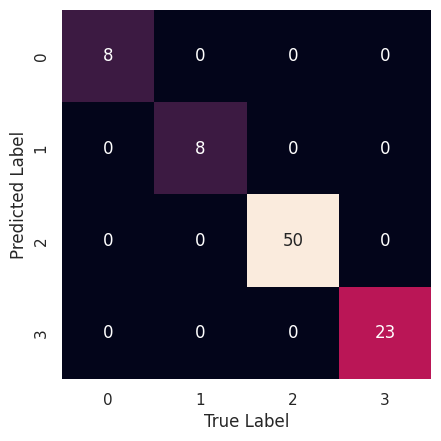

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Filter true labels and predicted labels to exclude instances with value 0
y_test_filtered = y_test[y_test != 0]
y_pred_filtered = y_pred[y_test != 0]

# Create the confusion matrix for the filtered data
mat = confusion_matrix(y_test_filtered, y_pred_filtered)

# Plot the confusion matrix heatmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()


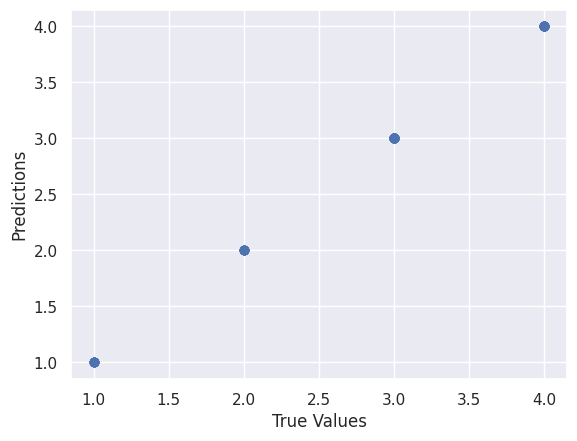

In [ ]:
import matplotlib.pyplot as plt
# Filter true labels and predicted labels to exclude instances with value 0
y_test_filtered = y_test[y_test != 0]
y_pred_filtered = y_pred[y_test != 0]

plt.scatter(y_test_filtered, y_pred_filtered)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

# **5. Generate Random Container Data**

In [ ]:
import numpy as np
import pandas as pd
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore


# # Load the trained random forest classifier from a joblib file
rfc_model = joblib.load("rfc_model.joblib")

# # Generate random stowage data
n_samples = 1000
cargo_types = ['1', '2', '3', '4',]
destinations = [1, 2, 3, 4]
data = pd.DataFrame({
    'id': np.arange(n_samples),
    'destinations': np.random.choice(destinations, n_samples),
    'cargo_type': np.random.choice(cargo_types, n_samples),
    'cargo_weight': np.random.randint(2000, 24000, n_samples),
    'Location': np.zeros(n_samples)
})

# # Save the data to a CSV file
data.to_csv('data2.csv', index=False)

# # Read data from CSV file
data = pd.read_csv('data2.csv')

# # # Extract relevant columns and convert to numpy array
matrix2 = data[['destinations', 'cargo_type', 'cargo_weight']].to_numpy()

In [ ]:
# Store the results in Firestore
db = firestore.client()
for i in range(len(data)):
    doc_ref = db.collection(u'containers').document(u'containers{}'.format(i))
    doc_ref.set({
        u'id': int(data['id'][i]),
        u'destinations': int(data['destinations'][i]),
        u'cargo_type': str(data['cargo_type'][i]),
        u'cargo_weight': int(data['cargo_weight'][i]),
    })

In [ ]:
!pip install qrcode


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 7.0 MB/s eta 0:00:00


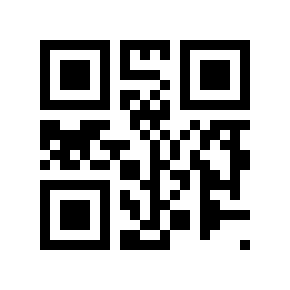

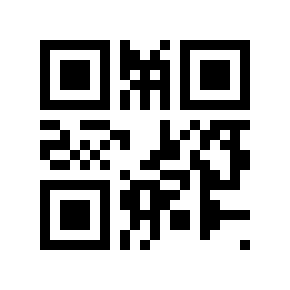

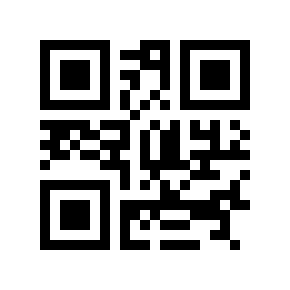

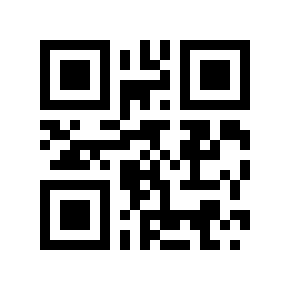

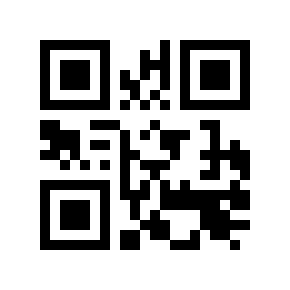

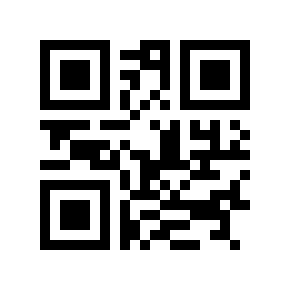

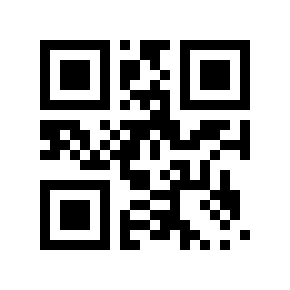

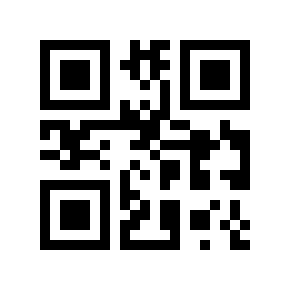

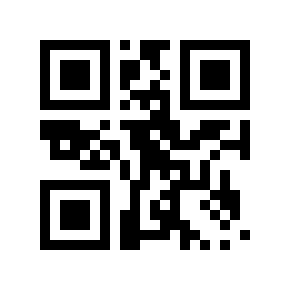

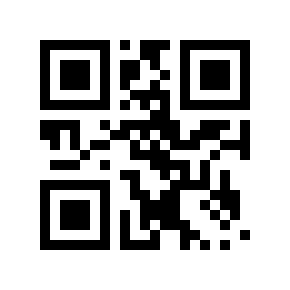

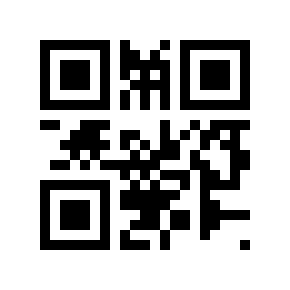

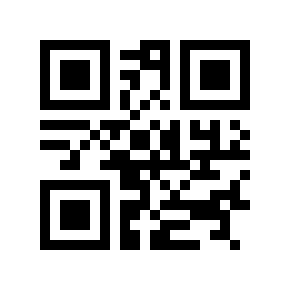

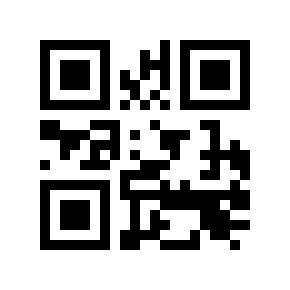

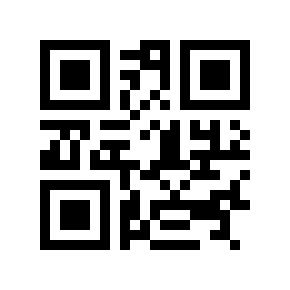

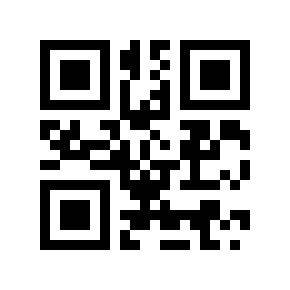

In [ ]:
import qrcode
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore


db = firestore.client()

# Define the list of document IDs to generate QR codes for
document_ids = ["containers744", "containers86",
                "containers244", "containers43",
                "containers902", "containers934",
                "containers259", "containers510",
                "containers207", "containers487",
                "containers36", "containers527",
                "containers312", "containers664",
                "containers504"]  # Add your desired document IDs here

# Generate QR code for each document ID
for document_id in document_ids:
    # Create a reference to the document
    doc_ref = db.collection("containers").document(document_id)

    # Retrieve the document data
    document = doc_ref.get()

    # Check if the document exists
    if document.exists:
        # Create a QR code instance
        qr = qrcode.QRCode(
            version=1,
            error_correction=qrcode.constants.ERROR_CORRECT_L,
            box_size=10,
            border=4,
        )

        # Add data to the QR code
        qr.add_data(document_id)

        # Make the QR code image
        qr.make(fit=True)

        # Get the QR code image as a PIL Image object
        qr_image = qr.make_image(fill_color="black", back_color="white")
        qr_image.save(f"qr_code_{document_id}.png")

        # Display the QR code image
        qr_image.show()
    else:
        print(f"Document with ID '{document_id}' does not exist in Firestore.")

Jeni

In [ ]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

# Reference to Firestore database
db = firestore.client()

# Retrieve data from Firestore
collection_ref = db.collection('sample')  # Replace 'your_collection' with your actual collection name

# Query documents in the collection
documents = collection_ref.get()

# Iterate over the documents and print their data
for document in documents:
    document_data = document.to_dict()
    print(document_data)


{'message': [{'cargo_type': '4', 'destinations': 1, 'title': 'containers744', 'id': 744, 'location': 0, 'cargo_weight': 10081}, {'id': 86, 'destinations': 1, 'title': 'containers86', 'cargo_type': '4', 'cargo_weight': 9895, 'location': 0}, {'cargo_type': '4', 'id': 902, 'cargo_weight': 17545, 'title': 'containers902', 'destinations': 4, 'location': 0}, {'destinations': 4, 'cargo_type': '4', 'title': 'containers934', 'cargo_weight': 15040, 'location': 0, 'id': 934}, {'location': 0, 'destinations': 2, 'cargo_type': '4', 'title': 'containers207', 'cargo_weight': 6377, 'id': 207}, {'cargo_weight': 14715, 'location': 0, 'title': 'containers487', 'destinations': 4, 'id': 487, 'cargo_type': '1'}, {'cargo_weight': 5529, 'cargo_type': '1', 'title': 'containers312', 'location': 0, 'destinations': 1, 'id': 312}, {'title': 'containers664', 'cargo_weight': 12304, 'destinations': 1, 'location': 0, 'cargo_type': '2', 'id': 664}]}


In [ ]:
import numpy as np
import pandas as pd


df = pd.DataFrame(document_data)

data_sample = pd.DataFrame(df['message'].values.tolist())
# Extract the list of dictionaries from the 'message' key
message_list = document_data['message']


matrix = data_sample[['destinations', 'cargo_type', 'cargo_weight']].to_numpy()
print(matrix)
print(data_sample)

[[1 '4' 10081]
 [1 '4' 9895]
 [4 '4' 17545]
 [4 '4' 15040]
 [2 '4' 6377]
 [4 '1' 14715]
 [1 '1' 5529]
 [1 '2' 12304]]
  cargo_type  destinations          title   id  location  cargo_weight
0          4             1  containers744  744         0         10081
1          4             1   containers86   86         0          9895
2          4             4  containers902  902         0         17545
3          4             4  containers934  934         0         15040
4          4             2  containers207  207         0          6377
5          1             4  containers487  487         0         14715
6          1             1  containers312  312         0          5529
7          2             1  containers664  664         0         12304


In [ ]:
 rfc_model = joblib.load("rfc_model.joblib")
 testrun3 = rfc_model.predict(matrix)
 testrun3

array([1, 1, 2, 2, 3, 3, 4, 4])

In [ ]:
# Create a new DataFrame with the predicted locations and IDs
results_pd = pd.DataFrame({
    'id': data_sample['id'],
    'destinations': data_sample['destinations'],
    'cargo_type': data_sample['cargo_type'],
    'cargo_weight': data_sample['cargo_weight'],
    'Location': testrun3
})

# Save the results to a CSV file
results_pd.to_csv('results.csv', index=False)

In [ ]:
results_pd

,id,destinations,cargo_type,cargo_weight,Location
0,744,1,4,10081,1
1,86,1,4,9895,1
2,902,4,4,17545,2
3,934,4,4,15040,2
4,207,2,4,6377,3
5,487,4,1,14715,3
6,312,1,1,5529,4
7,664,1,2,12304,4


In [ ]:
matrix_data = pd.read_csv('results.csv')
data = matrix_data.values
data
sum_val = 50000

In [ ]:
data =  np.save('results_modified.npy', data)

In [ ]:
def execute_prediction(data, sum_val):
    # Assuming the data is already loaded into a numpy array called matrix
    data = np.load('results_modified.npy')

    selected_containers = None
    selected_ids = []
    while selected_containers is None:
        loc_1 = data[data[:, 4] == 1, :]
        loc_2 = data[data[:, 4] == 2, :]
        loc_3 = data[data[:, 4] == 3, :]
        loc_4 = data[data[:, 4] == 4, :]
        loc_1 = loc_1[np.random.choice(loc_1.shape[0], 1), :]
        loc_2 = loc_2[np.random.choice(loc_2.shape[0], 1), :]
        loc_3 = loc_3[np.random.choice(loc_3.shape[0], 1), :]
        loc_4 = loc_4[np.random.choice(loc_4.shape[0], 1), :]


        total_weight = loc_1[:, 3] + loc_2[:, 3] + loc_3[:, 3] + loc_4[:, 3]
        if total_weight == sum_val + 1000 or sum_val - 1000:
          selected_containers = np.concatenate((loc_1, loc_2, loc_3, loc_4), axis=0)

    # Remove the selected rows from the data
    selected_ids.extend(selected_containers[:, 0].tolist())
    data = data[~np.isin(data[:, 0], selected_ids), :]

    # Put the selected containers into a matrix
    tier = selected_containers[:, [0, 1, 2, 3, 4]]

    # Save the modified data to a numpy array
    np.save('results_modified.npy', data)


    return tier


In [ ]:
#how many tiers do you want?
y = 1
loop = y*2
results = []
for i in range(loop):
    results.append(execute_prediction(data, sum_val))

In [ ]:
results

[array([[  744,     1,     4, 10081,     1],
        [  934,     4,     4, 15040,     2],
        [  207,     2,     4,  6377,     3],
        [  664,     1,     2, 12304,     4]]),
 array([[   86,     1,     4,  9895,     1],
        [  902,     4,     4, 17545,     2],
        [  487,     4,     1, 14715,     3],
        [  312,     1,     1,  5529,     4]])]

In [ ]:
for i, matrix in enumerate(results):
    if i % 2 == 1:
        matrix[0,4] = 5
        matrix[1,4] = 6
        matrix[2,4] = 7
        matrix[3,4] = 8

In [ ]:
results

[array([[  744,     1,     4, 10081,     1],
        [  934,     4,     4, 15040,     2],
        [  207,     2,     4,  6377,     3],
        [  664,     1,     2, 12304,     4]]),
 array([[   86,     1,     4,  9895,     5],
        [  902,     4,     4, 17545,     6],
        [  487,     4,     1, 14715,     7],
        [  312,     1,     1,  5529,     8]])]

In [ ]:
  import qrcode
  import io
  from google.cloud import storage

  # Initialize Firebase Storage client
  storage_client = storage.Client()

  # Store the results in Firestore and Firebase Storage
  db = firestore.client()
  bucket = storage_client.get_bucket('fir-ml-9258b.appspot.com')

  for i, result in enumerate(results):
      for j, container in enumerate(result):
          container_id = int(container[0])
          doc_name = u'containers{}'.format(container_id)
          doc_ref = db.collection(u'results').document(doc_name)
          qr_code_data = doc_name  # Set the QR code data as the document name

          # Generate the QR code image
          qr_code = qrcode.make(qr_code_data)

          # Create a BytesIO object to store the QR code image
          qr_code_buffer = io.BytesIO()
          qr_code.save(qr_code_buffer)
          qr_code_buffer.seek(0)

          # Upload the QR code image to Firebase Storage
          qr_code_filename = f'{doc_name}.png'
          blob = bucket.blob(qr_code_filename)
          blob.upload_from_file(qr_code_buffer, content_type='image/png')

          # Get the public URL of the uploaded QR code image
          qr_code_url = blob.public_url

          # Store the results in Firestore
          doc_ref.set({
              u'id': container_id,
              u'destinations': int(container[1]),
              u'cargo_type': str(container[2]),
              u'cargo_weight': int(container[3]),
              u'location': int(container[4]),
          })

          print("QR Code URL:", qr_code_url)


QR Code URL: https://storage.googleapis.com/fir-ml-9258b.appspot.com/containers744.png
QR Code URL: https://storage.googleapis.com/fir-ml-9258b.appspot.com/containers934.png
QR Code URL: https://storage.googleapis.com/fir-ml-9258b.appspot.com/containers207.png
QR Code URL: https://storage.googleapis.com/fir-ml-9258b.appspot.com/containers664.png
QR Code URL: https://storage.googleapis.com/fir-ml-9258b.appspot.com/containers86.png
QR Code URL: https://storage.googleapis.com/fir-ml-9258b.appspot.com/containers902.png
QR Code URL: https://storage.googleapis.com/fir-ml-9258b.appspot.com/containers487.png
QR Code URL: https://storage.googleapis.com/fir-ml-9258b.appspot.com/containers312.png


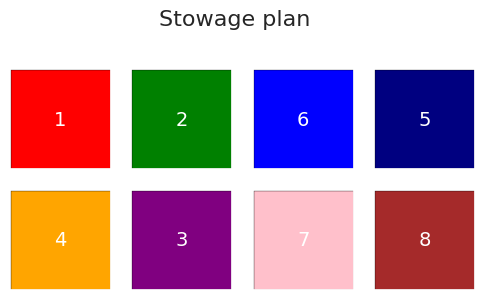

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from itertools import cycle

# this is to take the data from a dataframe
# colors = df['color'].to_numpy()
# colors =cycle(colors)

# Define the colors of the boxes
colors = cycle(['red', 'green', 'blue', 'navy', 'orange', 'purple', 'pink', 'brown'])
id = cycle(['1','2','6','5','4','3','7','8',])

# Create a 4x3 grid of subplots using GridSpec
fig = plt.figure(figsize=(6, 6))
gs = GridSpec(nrows=4, ncols=4, figure=fig)

# Iterate over each subplot
for i, (row, col) in enumerate([(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3)]):

    # Create a rectangle with a random color
    color = next(colors)
    ax = fig.add_subplot(gs[row, col])
    rect = plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black')
    ax.add_patch(rect)

    # Add text to the center of the rectangle
    text = next(id)
    ax.text(0.5, 0.5, s =text, ha='center', va='center', color='white', fontsize=14)
    # Remove the ticks and axis labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

# Set the title of the plot
fig.suptitle('Stowage plan', fontsize=16)

# Display the plot
plt.show()

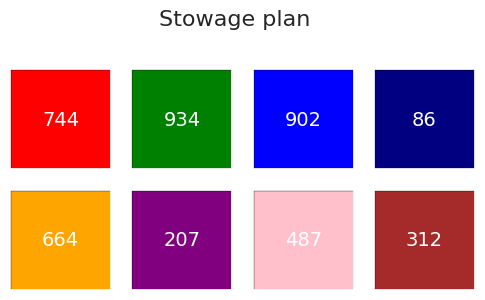

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from itertools import cycle
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

# Initialize Firestore
db = firestore.client()

# Define the colors of the boxes
colors = cycle(['red', 'green', 'purple', 'orange', 'navy',  'blue', 'pink', 'brown'])

# Create a 4x4 grid of subplots using GridSpec
fig = plt.figure(figsize=(6, 6))
gs = GridSpec(nrows=4, ncols=4, figure=fig)

# Iterate over each subplot
for i, (row, col) in enumerate([(0, 0), (0, 1), (1, 1), (1, 0), (0, 3), (0, 2), (1, 2), (1, 3)]):

    # Get container ID from Firestore based on location
    container_ref = db.collection("results").where("location", "==", i+1).get()

    if len(container_ref) == 0:
        container_id = "N/A"  # If container not found, display "N/A"
    else:
        container_data = container_ref[0].to_dict()
        container_id = container_data.get("id", "N/A")  # Get the "id" field value from the document

    # Create a rectangle with a random color
    color = next(colors)
    ax = fig.add_subplot(gs[row, col])
    rect = plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black')
    ax.add_patch(rect)

    # Add text to the center of the rectangle
    ax.text(0.5, 0.5, s=container_id, ha='center', va='center', color='white', fontsize=14)

    # Remove the ticks and axis labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

# Set the title of the plot
fig.suptitle('Stowage plan', fontsize=16)

# Display the plot
plt.show()
